In [1]:
experiment_name= "C2S_resnet34_semi_hard_margin_1"

In [5]:
import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.core.common import flatten
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import datasets
import networks
import utils

In [8]:
#######################################################
#                  Create Dataset
#######################################################
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ,
                              transforms.Normalize(mean, std)
                               ])

#######################################################
#                  Create Train Dataset
#######################################################
dataset_train = datasets.DeepFashionDataset(img_dir="../DeepFashion_C2S/images",train_path="../DeepFashion_C2S/DeepFashionDataset_train.csv",mode="train")
#triplet_dataset_train = datasets.TripletDeepFashion(dataset_train, mode="train")

#train_dataset = datasets.CarsDataset(transform, train=True)

#######################################################
#                  Create Valid Dataset
#######################################################
#dataset_valid = datasets.DeepFashionDataset(img_dir="./images",validation_path="DeepFashionDataset_validation.csv",mode="validation")
#triplet_dataset_valid = datasets.TripletDeepFashion(dataset_valid, mode="validation")

#######################################################
#                  Create Test Dataset
#######################################################
#dataset_test = datasets.DeepFashionDataset(img_dir="./images",test_path="DeepFashionDataset_test.csv",mode="test")
#triplet_dataset_test = datasets.TripletDeepFashion(dataset_test, mode="test")

In [9]:
len(dataset_train)

159062

In [10]:
len(dataset_train)

159062

In [15]:
len(dataset_train.labels_set)

17968

In [16]:
dataset_train.labels[:5]

array([0, 0, 0, 0, 0])

In [17]:
dataset_train.data[:5]

['CLOTHING/Blouse/id_00005025/comsumer_01.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_02.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_03.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_04.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_05.jpg']

In [18]:
dataset_train.classes[:5]

['CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025']

In [19]:
a= set(dataset_train.labels)

In [20]:
print(sorted(list(a)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [23]:
batch_size= 4
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [24]:
images.shape

(4, 3, 300, 300)

In [25]:
labels

tensor([ 4092,  6333,  9357, 13566])

In [26]:
print([dataset_train.idx_to_class[i.item()] for i in labels ])

['CLOTHING/Polo_Shirt/id_00012545', 'CLOTHING/T_Shirt/id_00013922', 'DRESSES/Dress/id_00003225', 'DRESSES/Dress/id_00014218']


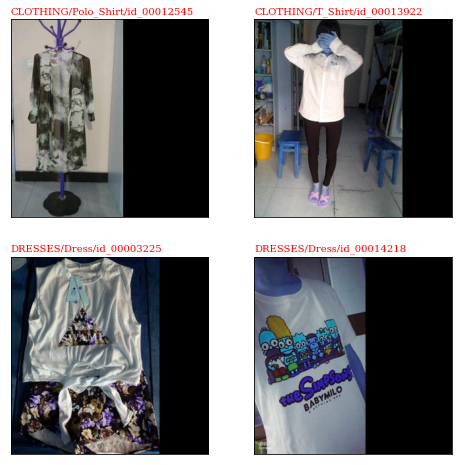

In [27]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_loader.dataset.classes[labels[idx].item()], fontfamily='serif', loc='left', fontsize='medium', color= 'red')


In [17]:
# check if CUDA is available
cuda = torch.cuda.is_available()

if not cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [18]:
dataset_train.labels

array([21, 21, 21, ...,  2,  2,  2])

In [19]:
from datasets import BalancedBatchSampler

# A mini batch is created by sampling n_classes and n_samples from each class:
train_batch_sampler = BalancedBatchSampler(dataset_train.labels, n_classes=10, n_samples=25)
#test_batch_sampler = BalancedBatchSampler(test_dataset.labels, n_classes=10, n_samples=25)

In [20]:
train_batch_sampler

In [21]:
online_train_loader = torch.utils.data.DataLoader(dataset_train, batch_sampler=train_batch_sampler)
#online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)

In [22]:
# Load the pretrained model from pytorch
embedding_net= torchvision.models.resnet34(pretrained=True)

# print out the model structure
print(embedding_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [24]:
embedding_net.fc= nn.Sequential(nn.Linear(512, 256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Linear(256, 128), # embedding size
                                )

In [25]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [26]:
model= networks.TripletNet(embedding_net)

In [27]:
from losses import OnlineTripletLoss
# Strategies for selecting triplets within a minibatch:
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector 

margin = 1
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))

In [28]:
import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.parameters(), lr=1e-3)

In [29]:
device = torch.device('cuda')
model.to(device)

TripletNet(
  (embedding_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [30]:
def train_epoch(train_loader, model, loss_fn, optimizer, log_interval, cuda):

    ###################
    # train the model #
    ###################
    model.train()

   # keep track of training loss
    train_loss = 0.0
    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        print(data)
        print(target)
        
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        
        # move tensors to GPU if CUDA is available
        if cuda:
            data = tuple(d.to(device) for d in data)
            if target is not None:
                target = tuple(t.to(device) for t in target)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: create embeddings of the inputs
        outputs = model.get_embedding(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        # append targets to the end of the embeddings, and calculate the batch loss
        loss_outputs = loss_fn(*loss_inputs)
        
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()

        losses.append(loss.item())
        
        # Provide some feedbach within one epoch
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))
            losses = []

    # calculate average train loss (batch average is returned)
    train_loss /= (batch_idx + 1)
    
    return train_loss

In [31]:
def test_epoch(val_loader, model, loss_fn, cuda):
    
    ######################    
    # validate the model #
    ######################
    
    # keep track of validation loss
    valid_loss = 0.0
    
    with torch.no_grad():

        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            
            if cuda:
                data = tuple(d.to(device) for d in data)
                if target is not None:
                    target = tuple(t.to(device) for t in target)
            
            outputs = model.get_embedding(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            
            # update average validation loss 
            valid_loss += loss.item()
            
    # calculate average validation loss (batch average is returned)
    valid_loss /= (batch_idx + 1)

    return valid_loss

In [32]:
def save_model(EPOCH, model, optimizer, LOSS): # epoch and loss are numbers
    """
    Save the trained model and the optimizer to disk.
    """      
    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.embedding_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, experiment_name+'.pt')

In [33]:
start_epoch= 0
n_epochs= 2

log_interval=10

train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(start_epoch, n_epochs):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_loss = train_epoch(online_train_loader, model, loss_fn, optimizer, log_interval, cuda)
    #valid_loss = test_epoch(online_test_loader, model, loss_fn, cuda)

    train_losses.append(train_loss)
    #valid_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, n_epochs, train_loss, valid_loss))
         
    '''
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( valid_loss_min,
                                                                                          valid_loss))
        save_model(epoch, model, optimizer, train_loss)
        valid_loss_min = valid_loss
    '''

./images/TOPS/Summer_Wear/id_00006413/comsumer_05.jpg
[[[196 210 198]
  [193 210 197]
  [207 224 211]
  ...
  [250 243 223]
  [250 243 223]
  [244 237 217]]

 [[197 211 199]
  [198 212 200]
  [212 226 214]
  ...
  [249 242 222]
  [249 242 222]
  [250 243 223]]

 [[196 211 197]
  [199 214 200]
  [214 228 216]
  ...
  [245 238 219]
  [244 237 218]
  [243 236 217]]

 ...

 [[ 14  26  32]
  [ 11  23  29]
  [ 17  29  35]
  ...
  [ 35  51  74]
  [ 35  53  82]
  [ 29  50  82]]

 [[ 14  26  32]
  [ 11  23  29]
  [ 16  28  34]
  ...
  [ 34  49  75]
  [ 31  51  82]
  [ 29  49  84]]

 [[ 15  27  33]
  [ 11  23  29]
  [ 17  27  34]
  ...
  [ 33  48  74]
  [ 30  50  81]
  [ 27  46  83]]]
./images/TOPS/Summer_Wear/id_00024816/comsumer_02.jpg
[[[242 232 225]
  [245 235 228]
  [247 237 230]
  ...
  [151 145 138]
  [154 148 141]
  [141 138 130]]

 [[243 233 226]
  [245 235 228]
  [247 237 230]
  ...
  [142 139 131]
  [147 141 134]
  [138 135 127]]

 [[243 233 226]
  [245 235 228]
  [248 238 231]
  ...


TypeError: expected np.ndarray (got NoneType)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# write training results:
f = open(experiment_name+ "_result"+".csv", "w")
f.write('\t'.join(('tr_er', 'val_er')))
f.write('\n')
for (tr_er, val_er) in zip(train_losses, valid_losses,):
    items= (str(tr_er),',', str(val_er))
    f.write('\t'.join(items))
    f.write('\n')
f.close()